In [5]:
import pandas as pd
from sklearn.metrics import root_mean_squared_error
import math
import numpy as np
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
pd.__version__

'2.2.3'

In [3]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import sys
print(sys.executable)

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/bin/python


In [8]:
import mlflow
from mlflow import tracking

tracking.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("pipeline experiment")


2025/05/28 07:51:12 INFO mlflow.tracking.fluent: Experiment with name 'pipeline experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/856538585974936517', creation_time=1748418672565, experiment_id='856538585974936517', last_update_time=1748418672565, lifecycle_stage='active', name='pipeline experiment', tags={}>

In [9]:
url1="https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet"

In [10]:
url2="https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet"

In [11]:
df=pd.read_parquet(url1)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,0.5,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.5,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0


In [12]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge',
       'cbd_congestion_fee'],
      dtype='object')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48326 entries, 0 to 48325
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               48326 non-null  int32         
 1   lpep_pickup_datetime   48326 non-null  datetime64[us]
 2   lpep_dropoff_datetime  48326 non-null  datetime64[us]
 3   store_and_fwd_flag     46490 non-null  object        
 4   RatecodeID             46490 non-null  float64       
 5   PULocationID           48326 non-null  int32         
 6   DOLocationID           48326 non-null  int32         
 7   passenger_count        46490 non-null  float64       
 8   trip_distance          48326 non-null  float64       
 9   fare_amount            48326 non-null  float64       
 10  extra                  48326 non-null  float64       
 11  mta_tax                48326 non-null  float64       
 12  tip_amount             48326 non-null  float64       
 13  t

In [18]:
def wrangle(filepath):
    df=pd.read_parquet(filepath)
    df["lpep_pickup_datetime"]=pd.to_datetime(df["lpep_pickup_datetime"])
    df["lpep_dropoff_datetime"]=pd.to_datetime(df["lpep_dropoff_datetime"])
    df["duration"]=df["lpep_dropoff_datetime"]-df["lpep_pickup_datetime"]
    df.duration=df.duration.apply(lambda td:td.total_seconds()/60)
    df=df[((df.duration>=1) & (df.duration<=60))]
    categorical=["PULocationID","DOLocationID"]
    #numerical=["trip_distance"]
    df[categorical]= df[categorical].astype(str)
    df['PU_DO']=df["PULocationID"]+ "_" +df["DOLocationID"]
    
    return df
    
        

In [19]:
df_train=wrangle(url1)
df_val=wrangle(url2)

In [20]:
df_train.tail()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration,PU_DO
48321,2,2025-01-31 19:36:00,2025-01-31 20:05:00,None,NaN,179,132,NaN,13.99,55.61,...,0.00,NaN,1.0,68.53,NaN,NaN,NaN,NaN,29.0,179_132
48322,2,2025-01-31 20:33:00,2025-01-31 20:41:00,None,NaN,166,75,NaN,1.51,13.58,...,0.00,NaN,1.0,17.34,NaN,NaN,NaN,NaN,8.0,166_75
48323,2,2025-01-31 21:09:00,2025-01-31 21:30:00,None,NaN,41,42,NaN,2.90,30.89,...,0.00,NaN,1.0,32.39,NaN,NaN,NaN,NaN,21.0,41_42
48324,2,2025-01-31 22:22:00,2025-01-31 22:25:00,None,NaN,75,43,NaN,0.34,14.78,...,0.00,NaN,1.0,18.72,NaN,NaN,NaN,NaN,3.0,75_43
48325,2,2025-01-31 22:15:00,2025-01-31 22:22:00,None,NaN,42,194,NaN,1.37,66.67,...,6.94,NaN,1.0,85.11,NaN,NaN,NaN,NaN,7.0,42_194


In [21]:
df_train.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee,duration,PU_DO
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0,14.183333,75_235
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0,5.883333,166_75
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0,1.866667,171_73
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0,15.466667,74_223
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0,36.083333,66_158


<Figure size 800x400 with 0 Axes>

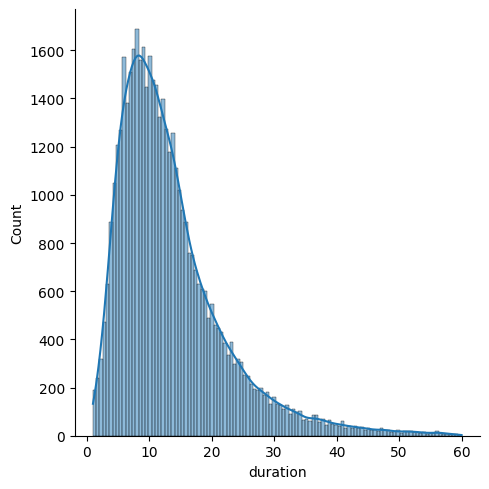

In [15]:
plt.figure(figsize=(8,4))
sns.displot(df_train.duration, kde=True);

In [16]:
df_train.duration.describe(percentiles=[0.5,0.6,0.7,0.8,0.95, 0.98, 0.99])

count    46307.000000
mean        13.493045
std          8.627705
min          1.000000
50%         11.450000
60%         13.283333
70%         15.500000
80%         18.833333
95%         30.600000
98%         38.981333
99%         44.916667
max         60.000000
Name: duration, dtype: float64

In [22]:
numerical=["trip_distance"]
categorical=["PU_DO"]

train_dicts=df_train[categorical + numerical].to_dict(orient="records")
dv=DictVectorizer()
X_train=dv.fit_transform(train_dicts)


val_dicts=df_val[categorical + numerical].to_dict(orient="records")
X_val=dv.transform(val_dicts)

In [23]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 92614 stored elements and shape (46307, 4159)>

In [24]:
# dv.feature_names_

In [25]:
target="duration"
y_train=df_train[target].values

y_val=df_val[target].values

In [26]:
from sklearn.linear_model import LinearRegression

In [27]:
model=LinearRegression()

In [28]:
model.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred=model.predict(X_val)

In [35]:
mse=mean_squared_error(y_val, y_pred)
mse

37.19645711556378

In [36]:
np.sqrt(mse)
 #rmse

np.float64(6.098889826481847)

In [28]:
with open ('/workspaces/mlops/01-intro/models/lin_reg.bin' , 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [29]:
with mlflow.start_run():
    mlflow.set_tag("engineer", "ethel")
    mlflow.log_param("january_data_url","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet")
    mlflow.log_param("february_data_url","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet")

    alpha=0.01
    mlflow.log_param("alpha", alpha)
    model1=Lasso(alpha)
    model1.fit(X_train, y_train)
    y_pred1=model1.predict(X_val)
    rmse=(np.sqrt(np.mean(np.square(y_val -  y_pred1))))
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="/workspaces/mlops/01-intro/models/lin_reg.bin", artifact_path="model_pickle")

🏃 View run whimsical-crow-917 at: http://127.0.0.1:5000/#/experiments/529620877340114925/runs/c259bd0725124194ad13ebca2cbe49e2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/529620877340114925


In [30]:
mean_squared_error(y_val, y_pred1)

58.5936270548088

In [31]:
import os
print(f"Current working directory: {os.getcwd()}")

Current working directory: /workspaces/mlops/experimental_tracking


In [37]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [38]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [34]:
def objective(params):
    with mlflow.start_run():
        mlflow.autolog(disable=True)
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        # Calculate RMSE directly
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [35]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:40:07] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:5.56082                           
[1]	validation-rmse:5.47437                           
[2]	validation-rmse:5.45786                           
[3]	validation-rmse:5.44497                           
[4]	validation-rmse:5.43636                           
[5]	validation-rmse:5.43478                           
[6]	validation-rmse:5.45349                           
[7]	validation-rmse:5.45062                           
[8]	validation-rmse:5.46096                           
[9]	validation-rmse:5.45825                           
[10]	validation-rmse:5.46552                          
[11]	validation-rmse:5.47429                          
[12]	validation-rmse:5.47651                          
[13]	validation-rmse:5.48640                          
[14]	validation-rmse:5.48388                          
[15]	validation-rmse:5.50307                          
[16]	validation-rmse:5.49619                          
[17]	validation-rmse:5.50149                          
[18]	valid

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:40:13] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:7.01735                                                    
[3]	validation-rmse:6.60328                                                    
[4]	validation-rmse:6.30153                                                    
[5]	validation-rmse:6.06316                                                    
[6]	validation-rmse:5.89327                                                    
[7]	validation-rmse:5.76432                                                    
[8]	validation-rmse:5.66437                                                    
[9]	validation-rmse:5.59659                                                    
[10]	validation-rmse:5.54730                                                   
[11]	validation-rmse:5.50183                                                   
[12]	validation-rmse:5.47062                                                   
[13]	validation-rmse:5.44809                                                   
[14]	validation-rmse:5.43316            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:40:19] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:5.57385                                                    
[1]	validation-rmse:5.56561                                                    
[2]	validation-rmse:5.56688                                                    
[3]	validation-rmse:5.56900                                                    
[4]	validation-rmse:5.57915                                                    
[5]	validation-rmse:5.58775                                                    
[6]	validation-rmse:5.59571                                                    
[7]	validation-rmse:5.59859                                                    
[8]	validation-rmse:5.60942                                                    
[9]	validation-rmse:5.61848                                                    
[10]	validation-rmse:5.62822                                                   
[11]	validation-rmse:5.62976                                                   
[12]	validation-rmse:5.64391            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:40:24] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.53035                                                    
[1]	validation-rmse:8.03128                                                    
[2]	validation-rmse:7.60405                                                    
[3]	validation-rmse:7.23857                                                    
[4]	validation-rmse:6.93127                                                    
[5]	validation-rmse:6.66737                                                    
[6]	validation-rmse:6.44588                                                    
[7]	validation-rmse:6.25945                                                    
[8]	validation-rmse:6.10528                                                    
[9]	validation-rmse:5.97639                                                    
[10]	validation-rmse:5.87146                                                   
[11]	validation-rmse:5.78155                                                   
[12]	validation-rmse:5.70920            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:40:36] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.33463                                                    
[1]	validation-rmse:7.70612                                                    
[2]	validation-rmse:7.21456                                                    
[3]	validation-rmse:6.81270                                                    
[4]	validation-rmse:6.50988                                                    
[5]	validation-rmse:6.26749                                                    
[6]	validation-rmse:6.08336                                                    
[7]	validation-rmse:5.94350                                                    
[8]	validation-rmse:5.83691                                                    
[9]	validation-rmse:5.75110                                                    
[10]	validation-rmse:5.69020                                                   
[11]	validation-rmse:5.64498                                                   
[12]	validation-rmse:5.61107            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:40:49] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.64593                                                    
[1]	validation-rmse:6.73688                                                    
[2]	validation-rmse:6.19972                                                    
[3]	validation-rmse:5.88655                                                    
[4]	validation-rmse:5.71854                                                    
[5]	validation-rmse:5.63348                                                    
[6]	validation-rmse:5.59492                                                    
[7]	validation-rmse:5.57410                                                    
[8]	validation-rmse:5.57609                                                    
[9]	validation-rmse:5.58208                                                    
[10]	validation-rmse:5.59256                                                   
[11]	validation-rmse:5.60201                                                   
[12]	validation-rmse:5.61131            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:40:58] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.99391                                                    
[1]	validation-rmse:7.19695                                                    
[2]	validation-rmse:6.64002                                                    
[3]	validation-rmse:6.25642                                                    
[4]	validation-rmse:5.98821                                                    
[5]	validation-rmse:5.83011                                                    
[6]	validation-rmse:5.71859                                                    
[7]	validation-rmse:5.65307                                                    
[8]	validation-rmse:5.61235                                                    
[9]	validation-rmse:5.58505                                                    
[10]	validation-rmse:5.56640                                                   
[11]	validation-rmse:5.55720                                                   
[12]	validation-rmse:5.56085            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:41:07] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.07466                                                    
[3]	validation-rmse:7.79421                                                    
[4]	validation-rmse:7.53790                                                    
[5]	validation-rmse:7.30928                                                    
[6]	validation-rmse:7.10148                                                    
[7]	validation-rmse:6.91657                                                    
[8]	validation-rmse:6.74961                                                    
[9]	validation-rmse:6.59923                                                    
[10]	validation-rmse:6.46729                                                   
[11]	validation-rmse:6.34380                                                   
[12]	validation-rmse:6.23884                                                   
[13]	validation-rmse:6.14207                                                   
[14]	validation-rmse:6.05673            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:41:20] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.77857                                                    
[1]	validation-rmse:8.47651                                                    
[2]	validation-rmse:8.19807                                                    
[3]	validation-rmse:7.94198                                                    
[4]	validation-rmse:7.70674                                                    
[5]	validation-rmse:7.49037                                                    
[6]	validation-rmse:7.29345                                                    
[7]	validation-rmse:7.11249                                                    
[8]	validation-rmse:6.94778                                                    
[9]	validation-rmse:6.79859                                                    
[10]	validation-rmse:6.66081                                                   
[11]	validation-rmse:6.53473                                                   
[12]	validation-rmse:6.42081            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:41:39] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[15]	validation-rmse:5.49061                                                   
[16]	validation-rmse:5.48745                                                   
[17]	validation-rmse:5.47574                                                   
[18]	validation-rmse:5.47016                                                   
[19]	validation-rmse:5.47550                                                   
[20]	validation-rmse:5.47602                                                   
[21]	validation-rmse:5.47293                                                   
[22]	validation-rmse:5.48045                                                   
[23]	validation-rmse:5.48010                                                   
[24]	validation-rmse:5.47671                                                   
[25]	validation-rmse:5.47804                                                   
[26]	validation-rmse:5.47909                                                   
[27]	validation-rmse:5.47403            

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:41:40] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.79541                                                     
[1]	validation-rmse:8.50938                                                     
[2]	validation-rmse:8.24627                                                     
[3]	validation-rmse:8.00463                                                     
[4]	validation-rmse:7.78311                                                     
[5]	validation-rmse:7.57932                                                     
[6]	validation-rmse:7.39263                                                     
[7]	validation-rmse:7.22351                                                     
[8]	validation-rmse:7.06972                                                     
[9]	validation-rmse:6.93171                                                     
[10]	validation-rmse:6.80209                                                    
[11]	validation-rmse:6.68548                                                    
[12]	validation-rmse:6.58047

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:42:36] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.36248                                                     
[1]	validation-rmse:7.75975                                                     
[2]	validation-rmse:7.26420                                                     
[3]	validation-rmse:6.87472                                                     
[4]	validation-rmse:6.55413                                                     
[5]	validation-rmse:6.30581                                                     
[6]	validation-rmse:6.10436                                                     
[7]	validation-rmse:5.95278                                                     
[8]	validation-rmse:5.83338                                                     
[9]	validation-rmse:5.74221                                                     
[10]	validation-rmse:5.67342                                                    
[11]	validation-rmse:5.61561                                                    
[12]	validation-rmse:5.57539

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:42:47] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[10]	validation-rmse:5.48939                                                    
[11]	validation-rmse:5.48522                                                    
[12]	validation-rmse:5.49025                                                    
[13]	validation-rmse:5.48589                                                    
[14]	validation-rmse:5.48739                                                    
[15]	validation-rmse:5.48835                                                    
[16]	validation-rmse:5.46436                                                    
[17]	validation-rmse:5.45976                                                    
[18]	validation-rmse:5.46306                                                    
[19]	validation-rmse:5.46827                                                    
[20]	validation-rmse:5.46372                                                    
[21]	validation-rmse:5.46587                                                    
[22]	validation-rmse:5.46668

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:42:49] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.74413                                                     
[1]	validation-rmse:6.85944                                                     
[2]	validation-rmse:6.31880                                                     
[3]	validation-rmse:5.97834                                                     
[4]	validation-rmse:5.79272                                                     
[5]	validation-rmse:5.68459                                                     
[6]	validation-rmse:5.63267                                                     
[7]	validation-rmse:5.60429                                                     
[8]	validation-rmse:5.59913                                                     
[9]	validation-rmse:5.60105                                                     
[10]	validation-rmse:5.60343                                                    
[11]	validation-rmse:5.61401                                                    
[12]	validation-rmse:5.62549

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:42:59] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:5.44297                                                     
[2]	validation-rmse:5.42435                                                     
[3]	validation-rmse:5.40562                                                     
[4]	validation-rmse:5.40510                                                     
[5]	validation-rmse:5.40890                                                     
[6]	validation-rmse:5.41606                                                     
[7]	validation-rmse:5.41544                                                     
[8]	validation-rmse:5.42950                                                     
[9]	validation-rmse:5.43828                                                     
[10]	validation-rmse:5.44582                                                    
[11]	validation-rmse:5.44686                                                    
[12]	validation-rmse:5.45523                                                    
[13]	validation-rmse:5.44846

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:43:01] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:6.99650                                                     
[2]	validation-rmse:6.41607                                                     
[3]	validation-rmse:6.03751                                                     
[4]	validation-rmse:5.79206                                                     
[5]	validation-rmse:5.63634                                                     
[6]	validation-rmse:5.54436                                                     
[7]	validation-rmse:5.48772                                                     
[8]	validation-rmse:5.45602                                                     
[9]	validation-rmse:5.43152                                                     
[10]	validation-rmse:5.41603                                                    
[11]	validation-rmse:5.40664                                                    
[12]	validation-rmse:5.39637                                                    
[13]	validation-rmse:5.39145

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:43:08] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:8.03086                                                     
[4]	validation-rmse:7.81005                                                     
[5]	validation-rmse:7.60722                                                     
[6]	validation-rmse:7.41921                                                     
[7]	validation-rmse:7.24598                                                     
[8]	validation-rmse:7.08763                                                     
[9]	validation-rmse:6.94010                                                     
[10]	validation-rmse:6.80774                                                    
[11]	validation-rmse:6.68281                                                    
[12]	validation-rmse:6.57032                                                    
[13]	validation-rmse:6.46714                                                    
[14]	validation-rmse:6.37146                                                    
[15]	validation-rmse:6.28512

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:43:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.44690                                                     
[1]	validation-rmse:7.90179                                                     
[2]	validation-rmse:7.44677                                                     
[3]	validation-rmse:7.07514                                                     
[4]	validation-rmse:6.77278                                                     
[5]	validation-rmse:6.53520                                                     
[6]	validation-rmse:6.33945                                                     
[7]	validation-rmse:6.18335                                                     
[8]	validation-rmse:6.05670                                                     
[9]	validation-rmse:5.96477                                                     
[10]	validation-rmse:5.88715                                                    
[11]	validation-rmse:5.82656                                                    
[12]	validation-rmse:5.78311

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:43:43] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.36427                                                     
[1]	validation-rmse:5.80477                                                     
[2]	validation-rmse:5.70805                                                     
[3]	validation-rmse:5.71031                                                     
[4]	validation-rmse:5.71867                                                     
[5]	validation-rmse:5.73061                                                     
[6]	validation-rmse:5.73863                                                     
[7]	validation-rmse:5.74061                                                     
[8]	validation-rmse:5.74380                                                     
[9]	validation-rmse:5.75147                                                     
[10]	validation-rmse:5.75634                                                    
[11]	validation-rmse:5.75741                                                    
[12]	validation-rmse:5.75957

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:43:54] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:5.87339
[4]	validation-rmse:5.66806                                                     
[5]	validation-rmse:5.54795                                                     
[6]	validation-rmse:5.46959                                                     
[7]	validation-rmse:5.41917                                                     
[8]	validation-rmse:5.39051                                                     
[9]	validation-rmse:5.36723                                                     
[10]	validation-rmse:5.35269                                                    
[11]	validation-rmse:5.34468                                                    
[12]	validation-rmse:5.33956                                                    
[13]	validation-rmse:5.32973                                                    
[14]	validation-rmse:5.32342                                                    
[15]	validation-rmse:5.32003                                                    


/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:43:59] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:6.29937                                                     
[2]	validation-rmse:5.81822                                                     
[3]	validation-rmse:5.58921                                                     
[4]	validation-rmse:5.47600                                                     
[5]	validation-rmse:5.41792                                                     
[6]	validation-rmse:5.39128                                                     
[7]	validation-rmse:5.37249                                                     
[8]	validation-rmse:5.35699                                                     
[9]	validation-rmse:5.34624                                                     
[10]	validation-rmse:5.33735                                                    
[11]	validation-rmse:5.32663                                                    
[12]	validation-rmse:5.32156                                                    
[13]	validation-rmse:5.31682

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:44:06] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:5.99442                                                     
[2]	validation-rmse:5.60850                                                     
[3]	validation-rmse:5.46608                                                     
[4]	validation-rmse:5.40915                                                     
[5]	validation-rmse:5.38973                                                     
[6]	validation-rmse:5.37569                                                     
[7]	validation-rmse:5.36819                                                     
[8]	validation-rmse:5.35847                                                     
[9]	validation-rmse:5.35383                                                     
[10]	validation-rmse:5.35881                                                    
[11]	validation-rmse:5.35624                                                    
[12]	validation-rmse:5.35518                                                    
[13]	validation-rmse:5.35169

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:44:11] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[12]	validation-rmse:6.09572                                                    
[13]	validation-rmse:6.01759                                                    
[14]	validation-rmse:5.94945                                                    
[15]	validation-rmse:5.89053                                                    
[16]	validation-rmse:5.84015                                                    
[17]	validation-rmse:5.79595                                                    
[18]	validation-rmse:5.75745                                                    
[19]	validation-rmse:5.72449                                                    
[20]	validation-rmse:5.69391                                                    
[21]	validation-rmse:5.66808                                                    
[22]	validation-rmse:5.64554                                                    
[23]	validation-rmse:5.62492                                                    
[24]	validation-rmse:5.60680

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:44:34] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[11]	validation-rmse:6.29940                                                    
[12]	validation-rmse:6.20383                                                    
[13]	validation-rmse:6.11873                                                    
[14]	validation-rmse:6.04376                                                    
[15]	validation-rmse:5.97856                                                    
[16]	validation-rmse:5.91969                                                    
[17]	validation-rmse:5.86850                                                    
[18]	validation-rmse:5.82338                                                    
[19]	validation-rmse:5.78389                                                    
[20]	validation-rmse:5.74724                                                    
[21]	validation-rmse:5.71563                                                    
[22]	validation-rmse:5.68750                                                    
[23]	validation-rmse:5.66254

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:44:56] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[8]	validation-rmse:6.54738                                                     
[9]	validation-rmse:6.41336                                                     
[10]	validation-rmse:6.29399                                                    
[11]	validation-rmse:6.19317                                                    
[12]	validation-rmse:6.10539                                                    
[13]	validation-rmse:6.02843                                                    
[14]	validation-rmse:5.96213                                                    
[15]	validation-rmse:5.90398                                                    
[16]	validation-rmse:5.85342                                                    
[17]	validation-rmse:5.80725                                                    
[18]	validation-rmse:5.76922                                                    
[19]	validation-rmse:5.73593                                                    
[20]	validation-rmse:5.70673

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:45:17] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.25793                                                     
[2]	validation-rmse:7.90237                                                     
[3]	validation-rmse:7.58827                                                     
[4]	validation-rmse:7.31003                                                     
[5]	validation-rmse:7.06499                                                     
[6]	validation-rmse:6.84978                                                     
[7]	validation-rmse:6.66049                                                     
[8]	validation-rmse:6.49529                                                     
[9]	validation-rmse:6.35131                                                     
[10]	validation-rmse:6.22524                                                    
[11]	validation-rmse:6.11572                                                    
[12]	validation-rmse:6.02153                                                    
[13]	validation-rmse:5.93854

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:45:38] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[14]	validation-rmse:6.15315                                                    
[15]	validation-rmse:6.08652                                                    
[16]	validation-rmse:6.02923                                                    
[17]	validation-rmse:5.97584                                                    
[18]	validation-rmse:5.92915                                                    
[19]	validation-rmse:5.88755                                                    
[20]	validation-rmse:5.85184                                                    
[21]	validation-rmse:5.82016                                                    
[22]	validation-rmse:5.79125                                                    
[23]	validation-rmse:5.76512                                                    
[24]	validation-rmse:5.74155                                                    
[25]	validation-rmse:5.72182                                                    
[26]	validation-rmse:5.70438

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:45:57] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.54923                                                     
[1]	validation-rmse:8.06700                                                     
[2]	validation-rmse:7.65155                                                     
[3]	validation-rmse:7.29407                                                     
[4]	validation-rmse:6.98891                                                     
[5]	validation-rmse:6.72964                                                     
[6]	validation-rmse:6.50932                                                     
[7]	validation-rmse:6.32279                                                     
[8]	validation-rmse:6.16492                                                     
[9]	validation-rmse:6.03348                                                     
[10]	validation-rmse:5.92203                                                    
[11]	validation-rmse:5.83016                                                    
[12]	validation-rmse:5.75353

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:46:10] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.43691                                                     
[2]	validation-rmse:6.88843                                                     
[3]	validation-rmse:6.47450                                                     
[4]	validation-rmse:6.17017                                                     
[5]	validation-rmse:5.94435                                                     
[6]	validation-rmse:5.77847                                                     
[7]	validation-rmse:5.66246                                                     
[8]	validation-rmse:5.58071                                                     
[9]	validation-rmse:5.52212                                                     
[10]	validation-rmse:5.48017                                                    
[11]	validation-rmse:5.44681                                                    
[12]	validation-rmse:5.42808                                                    
[13]	validation-rmse:5.41149

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:46:19] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.14802                                                     
[3]	validation-rmse:7.88033                                                     
[4]	validation-rmse:7.63640                                                     
[5]	validation-rmse:7.41418                                                     
[6]	validation-rmse:7.21159                                                     
[7]	validation-rmse:7.02772                                                     
[8]	validation-rmse:6.86125                                                     
[9]	validation-rmse:6.71004                                                     
[10]	validation-rmse:6.57415                                                    
[11]	validation-rmse:6.45088                                                    
[12]	validation-rmse:6.33918                                                    
[13]	validation-rmse:6.23934                                                    
[14]	validation-rmse:6.14881

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:46:39] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[3]	validation-rmse:7.37731                                                     
[4]	validation-rmse:7.07892                                                     
[5]	validation-rmse:6.82387                                                     
[6]	validation-rmse:6.60410                                                     
[7]	validation-rmse:6.41757                                                     
[8]	validation-rmse:6.25763                                                     
[9]	validation-rmse:6.12294                                                     
[10]	validation-rmse:6.00925                                                    
[11]	validation-rmse:5.91228                                                    
[12]	validation-rmse:5.83045                                                    
[13]	validation-rmse:5.76163                                                    
[14]	validation-rmse:5.70373                                                    
[15]	validation-rmse:5.65470

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:46:51] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:6.16366                                                     
[7]	validation-rmse:6.00816                                                     
[8]	validation-rmse:5.87953                                                     
[9]	validation-rmse:5.78278                                                     
[10]	validation-rmse:5.70048                                                    
[11]	validation-rmse:5.64013                                                    
[12]	validation-rmse:5.58496                                                    
[13]	validation-rmse:5.54629                                                    
[14]	validation-rmse:5.51346                                                    
[15]	validation-rmse:5.48401                                                    
[16]	validation-rmse:5.46348                                                    
[17]	validation-rmse:5.44472                                                    
[18]	validation-rmse:5.42651

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:46:58] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.20038                                                     
[1]	validation-rmse:7.49382                                                     
[2]	validation-rmse:6.95137                                                     
[3]	validation-rmse:6.54732                                                     
[4]	validation-rmse:6.24485                                                     
[5]	validation-rmse:6.02196                                                     
[6]	validation-rmse:5.86198                                                     
[7]	validation-rmse:5.74725                                                     
[8]	validation-rmse:5.66710                                                     
[9]	validation-rmse:5.61216                                                     
[10]	validation-rmse:5.57282                                                    
[11]	validation-rmse:5.54642                                                    
[12]	validation-rmse:5.52860

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:47:10] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.44383                                                     
[1]	validation-rmse:7.88529                                                     
[2]	validation-rmse:7.41991                                                     
[3]	validation-rmse:7.03833                                                     
[4]	validation-rmse:6.72715                                                     
[5]	validation-rmse:6.46555                                                     
[6]	validation-rmse:6.26021                                                     
[7]	validation-rmse:6.08744                                                     
[8]	validation-rmse:5.95086                                                     
[9]	validation-rmse:5.83886                                                     
[10]	validation-rmse:5.74920                                                    
[11]	validation-rmse:5.67996                                                    
[12]	validation-rmse:5.61899

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:47:17] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.28264                                                     
[2]	validation-rmse:6.70953                                                     
[3]	validation-rmse:6.30752                                                     
[4]	validation-rmse:6.01836                                                     
[5]	validation-rmse:5.82695                                                     
[6]	validation-rmse:5.68769                                                     
[7]	validation-rmse:5.60012                                                     
[8]	validation-rmse:5.53599                                                     
[9]	validation-rmse:5.49164                                                     
[10]	validation-rmse:5.46227                                                    
[11]	validation-rmse:5.44129                                                    
[12]	validation-rmse:5.42765                                                    
[13]	validation-rmse:5.41694

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:47:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:7.10274                                                     
[3]	validation-rmse:6.69594                                                     
[4]	validation-rmse:6.37754                                                     
[5]	validation-rmse:6.13255                                                     
[6]	validation-rmse:5.94184                                                     
[7]	validation-rmse:5.79737                                                     
[8]	validation-rmse:5.68448                                                     
[9]	validation-rmse:5.60447                                                     
[10]	validation-rmse:5.54196                                                    
[11]	validation-rmse:5.49306                                                    
[12]	validation-rmse:5.45889                                                    
[13]	validation-rmse:5.43156                                                    
[14]	validation-rmse:5.40829

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:47:28] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.47157                                                     
[1]	validation-rmse:6.54696                                                     
[2]	validation-rmse:6.03021                                                     
[3]	validation-rmse:5.76158                                                     
[4]	validation-rmse:5.62488                                                     
[5]	validation-rmse:5.56497                                                     
[6]	validation-rmse:5.52705                                                     
[7]	validation-rmse:5.51599                                                     
[8]	validation-rmse:5.51220                                                     
[9]	validation-rmse:5.51199                                                     
[10]	validation-rmse:5.51680                                                    
[11]	validation-rmse:5.51730                                                    
[12]	validation-rmse:5.52171

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:47:33] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:7.24075                                                     
[2]	validation-rmse:6.67336                                                     
[3]	validation-rmse:6.28548                                                     
[4]	validation-rmse:6.00389                                                     
[5]	validation-rmse:5.81761                                                     
[6]	validation-rmse:5.68516                                                     
[7]	validation-rmse:5.59745                                                     
[8]	validation-rmse:5.52952                                                     
[9]	validation-rmse:5.48675                                                     
[10]	validation-rmse:5.45729                                                    
[11]	validation-rmse:5.43233                                                    
[12]	validation-rmse:5.41640                                                    
[13]	validation-rmse:5.40091

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:47:38] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[6]	validation-rmse:6.42260                                                     
[7]	validation-rmse:6.24820                                                     
[8]	validation-rmse:6.10728                                                     
[9]	validation-rmse:5.98446                                                     
[10]	validation-rmse:5.88523                                                    
[11]	validation-rmse:5.80381                                                    
[12]	validation-rmse:5.73350                                                    
[13]	validation-rmse:5.67810                                                    
[14]	validation-rmse:5.63386                                                    
[15]	validation-rmse:5.59613                                                    
[16]	validation-rmse:5.56423                                                    
[17]	validation-rmse:5.53679                                                    
[18]	validation-rmse:5.51237

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:47:49] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:8.07312                                                     
[3]	validation-rmse:7.78919                                                     
[4]	validation-rmse:7.53359                                                     
[5]	validation-rmse:7.30095                                                     
[6]	validation-rmse:7.09442                                                     
[7]	validation-rmse:6.90839                                                     
[8]	validation-rmse:6.73938                                                     
[9]	validation-rmse:6.58966                                                     
[10]	validation-rmse:6.45236                                                    
[11]	validation-rmse:6.33373                                                    
[12]	validation-rmse:6.22303                                                    
[13]	validation-rmse:6.12746                                                    
[14]	validation-rmse:6.04143

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:47:59] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.34366                                                     
[1]	validation-rmse:7.72281                                                     
[2]	validation-rmse:7.22120                                                     
[3]	validation-rmse:6.81800                                                     
[4]	validation-rmse:6.49792                                                     
[5]	validation-rmse:6.24062                                                     
[6]	validation-rmse:6.04107                                                     
[7]	validation-rmse:5.88722                                                     
[8]	validation-rmse:5.76742                                                     
[9]	validation-rmse:5.67542                                                     
[10]	validation-rmse:5.60631                                                    
[11]	validation-rmse:5.55328                                                    
[12]	validation-rmse:5.51405

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:48:13] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:5.87903                                                     
[2]	validation-rmse:5.56778                                                     
[3]	validation-rmse:5.46299                                                     
[4]	validation-rmse:5.42181                                                     
[5]	validation-rmse:5.39790                                                     
[6]	validation-rmse:5.39253                                                     
[7]	validation-rmse:5.38712                                                     
[8]	validation-rmse:5.38367                                                     
[9]	validation-rmse:5.38127                                                     
[10]	validation-rmse:5.38001                                                    
[11]	validation-rmse:5.37688                                                    
[12]	validation-rmse:5.36773                                                    
[13]	validation-rmse:5.36692

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:48:16] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.80686                                                     
[1]	validation-rmse:8.52900                                                     
[2]	validation-rmse:8.26902                                                     
[3]	validation-rmse:8.03053                                                     
[4]	validation-rmse:7.80776                                                     
[5]	validation-rmse:7.60418                                                     
[6]	validation-rmse:7.41565                                                     
[7]	validation-rmse:7.24489                                                     
[8]	validation-rmse:7.08682                                                     
[9]	validation-rmse:6.94286                                                     
[10]	validation-rmse:6.80815                                                    
[11]	validation-rmse:6.68556                                                    
[12]	validation-rmse:6.57395

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:48:42] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.67786                                                     
[1]	validation-rmse:8.29751                                                     
[2]	validation-rmse:7.95693                                                     
[3]	validation-rmse:7.65562                                                     
[4]	validation-rmse:7.38455                                                     
[5]	validation-rmse:7.14770                                                     
[6]	validation-rmse:6.93524                                                     
[7]	validation-rmse:6.75325                                                     
[8]	validation-rmse:6.58633                                                     
[9]	validation-rmse:6.44567                                                     
[10]	validation-rmse:6.31478                                                    
[11]	validation-rmse:6.20606                                                    
[12]	validation-rmse:6.10863

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:48:59] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:6.82598                                                     
[3]	validation-rmse:6.41754                                                     
[4]	validation-rmse:6.11657                                                     
[5]	validation-rmse:5.89980                                                     
[6]	validation-rmse:5.74378                                                     
[7]	validation-rmse:5.63195                                                     
[8]	validation-rmse:5.55477                                                     
[9]	validation-rmse:5.49889                                                     
[10]	validation-rmse:5.46100                                                    
[11]	validation-rmse:5.43428                                                    
[12]	validation-rmse:5.41415                                                    
[13]	validation-rmse:5.40119                                                    
[14]	validation-rmse:5.38848

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:49:07] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validation-rmse:8.10899                                                     
[2]	validation-rmse:7.70127                                                     
[3]	validation-rmse:7.35258                                                     
[4]	validation-rmse:7.04772                                                     
[5]	validation-rmse:6.78659                                                     
[6]	validation-rmse:6.56549                                                     
[7]	validation-rmse:6.37442                                                     
[8]	validation-rmse:6.21219                                                     
[9]	validation-rmse:6.07247                                                     
[10]	validation-rmse:5.95660                                                    
[11]	validation-rmse:5.85697                                                    
[12]	validation-rmse:5.77495                                                    
[13]	validation-rmse:5.70488

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:49:17] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[7]	validation-rmse:5.56863                                                     
[8]	validation-rmse:5.50834                                                     
[9]	validation-rmse:5.46901                                                     
[10]	validation-rmse:5.43847                                                    
[11]	validation-rmse:5.41800                                                    
[12]	validation-rmse:5.40040                                                    
[13]	validation-rmse:5.38932                                                    
[14]	validation-rmse:5.38013                                                    
[15]	validation-rmse:5.37283                                                    
[16]	validation-rmse:5.36655                                                    
[17]	validation-rmse:5.36066                                                    
[18]	validation-rmse:5.35321                                                    
[19]	validation-rmse:5.34887

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:49:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.75096                                                     
[1]	validation-rmse:8.42476                                                     
[2]	validation-rmse:8.12980                                                     
[3]	validation-rmse:7.86202                                                     
[4]	validation-rmse:7.61540                                                     
[5]	validation-rmse:7.39508                                                     
[6]	validation-rmse:7.19017                                                     
[7]	validation-rmse:7.00889                                                     
[8]	validation-rmse:6.84163                                                     
[9]	validation-rmse:6.69436                                                     
[10]	validation-rmse:6.55922                                                    
[11]	validation-rmse:6.44297                                                    
[12]	validation-rmse:6.33453

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:49:43] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validation-rmse:7.27663                                                     
[3]	validation-rmse:6.88474                                                     
[4]	validation-rmse:6.56333                                                     
[5]	validation-rmse:6.31537                                                     
[6]	validation-rmse:6.11398                                                     
[7]	validation-rmse:5.95624                                                     
[8]	validation-rmse:5.83373                                                     
[9]	validation-rmse:5.73759                                                     
[10]	validation-rmse:5.66044                                                    
[11]	validation-rmse:5.60370                                                    
[12]	validation-rmse:5.55457                                                    
[13]	validation-rmse:5.51811                                                    
[14]	validation-rmse:5.48440

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:49:49] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[12]	validation-rmse:5.53326                                                    
[13]	validation-rmse:5.52284                                                    
[14]	validation-rmse:5.51753                                                    
[15]	validation-rmse:5.51265                                                    
[16]	validation-rmse:5.51332                                                    
[17]	validation-rmse:5.50797                                                    
[18]	validation-rmse:5.49840                                                    
[19]	validation-rmse:5.49620                                                    
[20]	validation-rmse:5.49560                                                    
[21]	validation-rmse:5.48853                                                    
[22]	validation-rmse:5.48614                                                    
[23]	validation-rmse:5.48068                                                    
[24]	validation-rmse:5.48159

In [41]:
# with mlflow.start_run():
#     train = xgb.DMatrix(X_train, label=y_train)
#     valid = xgb.DMatrix(X_val, label=y_val)
    


#     best_params={ 
#     "reg_alpha":0.015143662957798473,
#     "seed" :42,
#     "learning_rate":0.2635721416413519,
#     "objective": "reg:linear",
#     "min_child_weight" :11.354716447890874,
#     "max_depth" :6,
#     "reg_lambda" :0.006716153330161491
    
#     }
    
#     mlflow.xgboost.autolog()
#     booster = xgb.train(
#                 params=best_params,
#                 dtrain=train,
#                 num_boost_round=1000,
#                 evals=[(valid, 'validation')],
#                 early_stopping_rounds=50
#             )

🏃 View run capable-finch-210 at: http://127.0.0.1:5000/#/experiments/529620877340114925/runs/a1202f8e573a4c00a6fe8b409a4f9711
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/529620877340114925


In [37]:
# sns.distplot(y_pred1, label="predictions")
# sns.distplot(y_train, label="original")
# plt.legend()

In [45]:
import os

In [46]:
mlflow.xgboost.autolog(disable=True)

In [48]:
with mlflow.start_run():
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)
    best_params={
        "reg_alpha": 0.015143662957798473,
        "seed": 42,
        "learning_rate": 0.2635721416413519,
        "objective": "reg:linear",
        "min_child_weight": 11.354716447890874,
        "max_depth": 6,
        "reg_lambda": 0.006716153330161491
    }
    mlflow.log_params(best_params)
    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )
    y_pred = booster.predict(valid) 
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    new_models_dir = "/workspaces/mlops/ml_pipelines/model"
    os.makedirs(new_models_dir, exist_ok=True)
    preprocessor_full_path = os.path.join(new_models_dir, "preprocessor.b")
    with open(preprocessor_full_path, "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact(preprocessor_full_path, artifact_path="preprocessor")
    mlflow.log_metric("rmse", rmse)
    mlflow.xgboost.log_model(booster, "models_mlflow")
    print(f"Preprocessor saved to and logged from: {preprocessor_full_path}")
    print("Other metrics and model logged successfully.")

[0]	validation-rmse:7.77958
[1]	validation-rmse:6.93542
[2]	validation-rmse:6.41764
[3]	validation-rmse:6.10787


/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [08:27:21] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[4]	validation-rmse:5.91626
[5]	validation-rmse:5.80696
[6]	validation-rmse:5.73155
[7]	validation-rmse:5.68815
[8]	validation-rmse:5.65851
[9]	validation-rmse:5.63742
[10]	validation-rmse:5.62288
[11]	validation-rmse:5.61110
[12]	validation-rmse:5.60125
[13]	validation-rmse:5.59364
[14]	validation-rmse:5.58739
[15]	validation-rmse:5.58451
[16]	validation-rmse:5.58173
[17]	validation-rmse:5.57915
[18]	validation-rmse:5.57310
[19]	validation-rmse:5.57103
[20]	validation-rmse:5.56891
[21]	validation-rmse:5.56685
[22]	validation-rmse:5.56446
[23]	validation-rmse:5.56130
[24]	validation-rmse:5.55865
[25]	validation-rmse:5.55708
[26]	validation-rmse:5.55525
[27]	validation-rmse:5.55347
[28]	validation-rmse:5.55115
[29]	validation-rmse:5.54931
[30]	validation-rmse:5.54746
[31]	validation-rmse:5.54592
[32]	validation-rmse:5.54306
[33]	validation-rmse:5.54093
[34]	validation-rmse:5.53789
[35]	validation-rmse:5.53605
[36]	validation-rmse:5.53489
[37]	validation-rmse:5.53283
[38]	validation-rmse

/home/codespace/.local/share/virtualenvs/mlops-YYCOetdN/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [08:27:48] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/05/28 08:27:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Preprocessor saved to and logged from: /workspaces/mlops/ml_pipelines/model/preprocessor.b
Other metrics and model logged successfully.
🏃 View run trusting-gnat-791 at: http://127.0.0.1:5000/#/experiments/856538585974936517/runs/6ecd18a00f85416398756c8e86b62ec8
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/856538585974936517


🏃 View run bedecked-mare-491 at: http://127.0.0.1:5000/#/experiments/529620877340114925/runs/fcddffa903004dae85d50851818390ae
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/529620877340114925


In [40]:
import mlflow
logged_model = 'runs:/0ffb8c77aec94773aaaa1a1dd8eb11bf/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


In [41]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.xgboost
  run_id: 0ffb8c77aec94773aaaa1a1dd8eb11bf

In [42]:
xgboost_model=mlflow.xgboost.load_model(logged_model)

In [43]:
xgboost_model

In [44]:
y_pred=xgboost_model.predict(valid)
y_pred[:11]

array([ 5.0229096, 26.532072 , 25.091501 , 14.004676 ,  9.594723 ,
       12.7178955,  6.223456 , 23.504082 , 22.394407 , 10.882504 ,
       10.170982 ], dtype=float32)